In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import axes3d
# patch start [https://stackoverflow.com/questions/16488182/removing-axes-margins-in-3d-plot]
from mpl_toolkits.mplot3d.axis3d import Axis
def _get_coord_info_new(self, renderer):
    mins, maxs, cs, deltas, tc, highs = self._get_coord_info_old(renderer)
    correction = deltas * [1.0/4 + 6.0/11,
                           1.0/4 + 6.0/11,
                           1.0/4]
    mins += correction
    maxs -= correction
    return mins, maxs, cs, deltas, tc, highs
if not hasattr(Axis, "_get_coord_info_old"):
    Axis._get_coord_info_old = Axis._get_coord_info  
Axis._get_coord_info = _get_coord_info_new
#patch end
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})


## [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation)
The viscous Burgers' equation is a [conservation law](https://en.wikipedia.org/wiki/Conservation_law), more generally a first order quasi-linear [hyperbolic equation](https://en.wikipedia.org/wiki/Hyperbolic_partial_differential_equation). 

$$
u_t + u u_x = \nu u_{xx}.
$$

It is made of terms we have seen before. The right hand side is the same term we have seen in the heat equation $\nu u_{xx}$ which acted to diffuse high frequency modes. The $u u_x$ term is just like the term in the linear wave equation $u_t + c u_x =0$ which made everything advect at speed c. However, here now that speed at which $u$ is advected across the grid itself is given by $u$. This means regions with larger $u$ will want to move faster than regions with lower $u$.


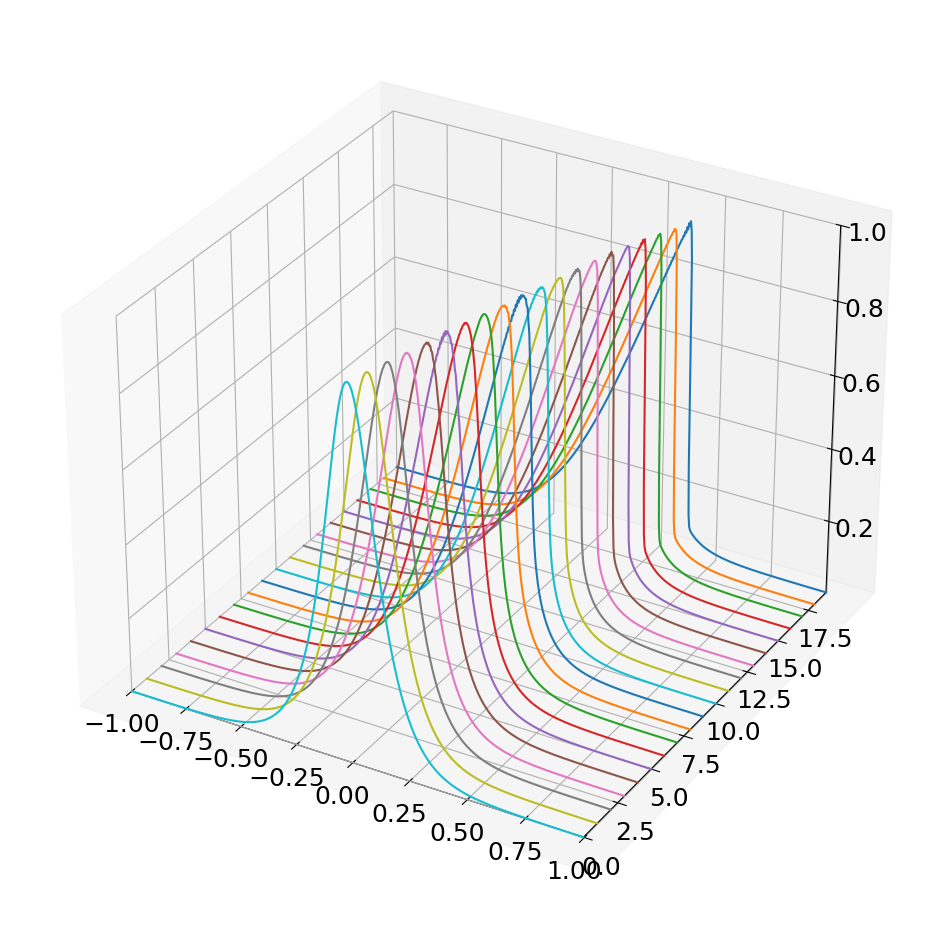

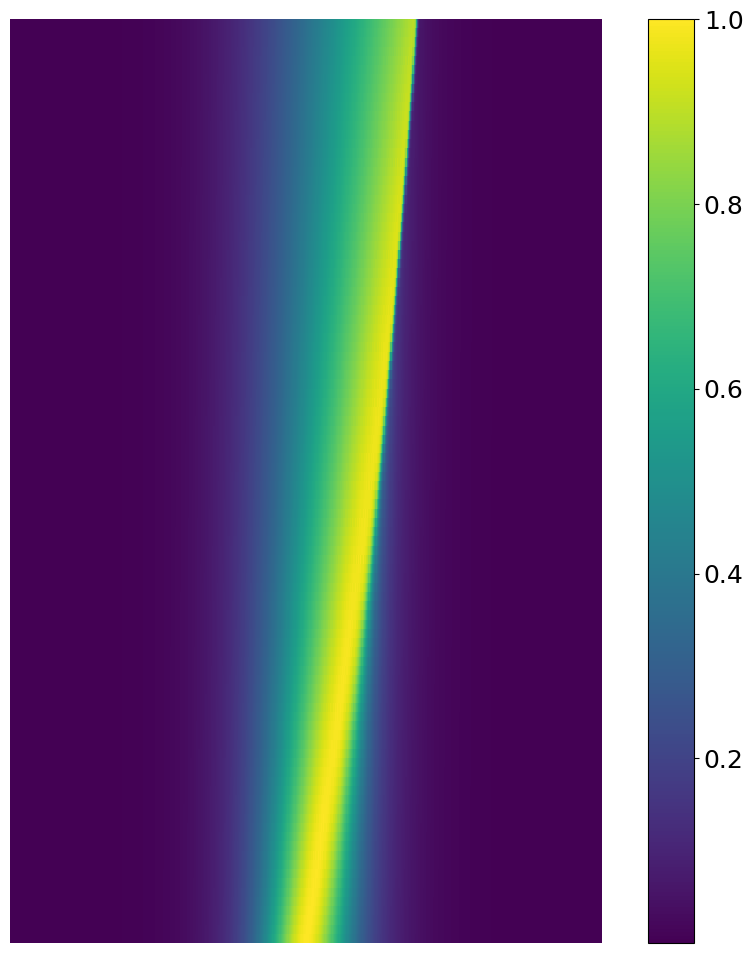

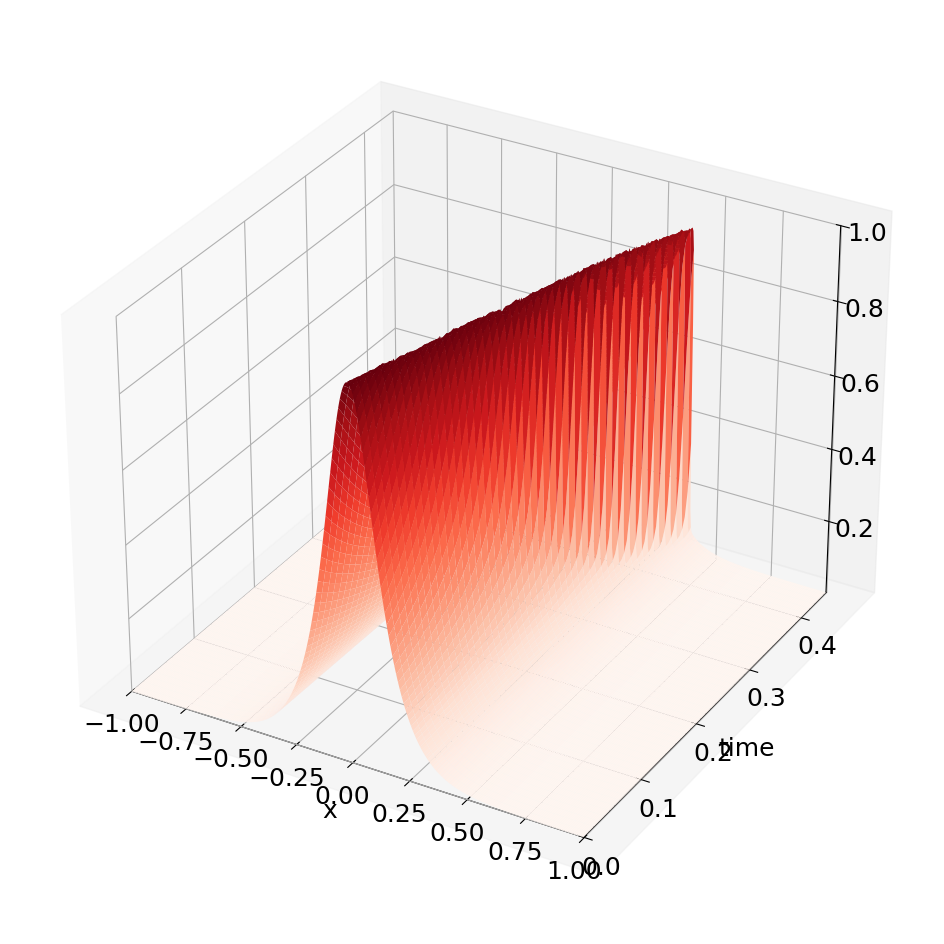

In [22]:

nu = 0.001    # Viscosity parameter
L = 2   # Length of domain
N = 512 # Number of discretization points
Nt = 100
dx = L/N
Tfinal = 0.45
x = np.arange(-L/2,L/2,dx) # Define x domain
pulse = False
# Define discrete wave-numbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x/(L/20))

# Simulate in real space but using fourier derivatives
t = np.linspace(0, Tfinal, Nt)
dt = Tfinal/Nt

def rhsBurgers(t,u,kappa,nu):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    dd_uhat = -kappa**2*uhat
    d_u = np.fft.ifft(d_uhat)
    dd_u = np.fft.ifft(dd_uhat)
    du_dt = -u * d_u + nu*dd_u
    return du_dt.real

sol = solve_ivp(rhsBurgers, (t[0],t[-1]), u0, args=(kappa,nu), t_eval=t )

u = sol.y.T

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u_plot = u[0:-1:5,:]
for j in range(u_plot.shape[0])[::-1]:
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])
    
# Image plot
plt.figure()
plt.imshow(np.flipud(u), aspect=8, interpolation="none")
plt.colorbar()
plt.axis('off')
plt.show()

X, Y = np.meshgrid(x, t)
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, u,  cmap="Reds", antialiased=True, rstride=2,cstride=2);
ax.set_xlabel("x")
ax.set_ylabel("time");

In [3]:
u_plot.shape

(20, 512)

## Conservation equations

The Burgers' equation we studied above is indeed the correct equation for the rate of change of the velocity neglecting pressure forces and external forces (such as gravity). Imagine a fluid moving in a one-dimensional system (think the center of a long pipe) we can now ask how does the density of the material changes given this velocity. We have to specify what the density looks like at the initial time, $\rho(x,t=0)$, and need an evolution equation of how it changes over time. This is provided by the continuity equation 

$$
\rho_t + \nabla \cdot (\rho \, u) = 0
$$ 

which in 1 dimension is

$$
\rho_t + (\rho \, u)_x = \rho_t + u \, \rho_x  + \rho \, u_x = 0
$$

In [25]:

nu = 0.009    # Viscosity parameter
L = 2   # Length of domain
N = 512 # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
#u0 = 1/np.cosh(x/(L/20))
#u0hat = np.fft.fft(u0)

rho0 = np.ones_like(x) # uniform density = 1 initially
U0 = np.concatenate((rho0,u0)) # state vector: first half is the density and second is the velocity

def rhsBurgersAdv(t, U,kappa,nu):
    N2 = len(U)//2
    rho = U[0:N]
    u   = U[N:]
    urho = u*rho
    # derivatives of rho
    urhohat = np.fft.fft(urho)
    d_urhohat = (1j)*kappa*urhohat
    d_urho = np.fft.ifft(d_urhohat)
    #derivatives of u
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    dd_uhat = -kappa**2*uhat
    d_u = np.fft.ifft(d_uhat)
    dd_u = np.fft.ifft(dd_uhat)
    # now assemble the time derivatives
    du_dt = -u * d_u + nu*dd_u
    drho_dt = -d_urho
    return np.concatenate((drho_dt.real, du_dt.real))

sol = solve_ivp(rhsBurgersAdv, (t[0],t[-1]), U0, args=(kappa,nu), t_eval=t, rtol=1e-7 )
U_adv = sol.y.T

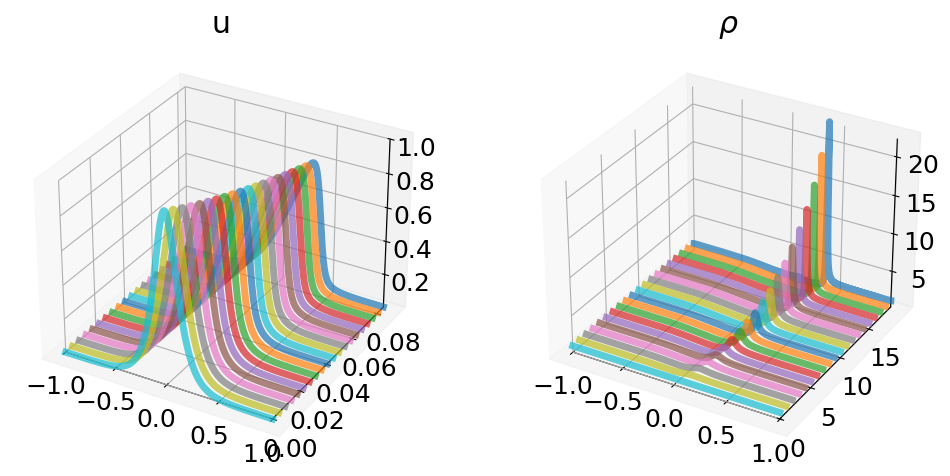

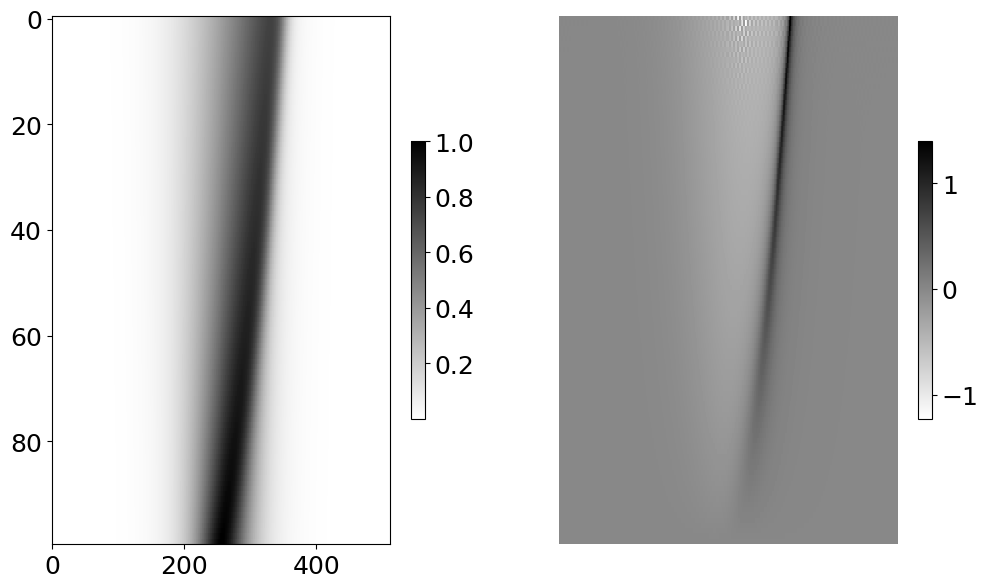

In [26]:
U = U_adv
plt.rcParams['image.cmap'] = 'binary'
# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.set_title("u")
u_plot = U[0:-1:5,N:]
for j in range(u_plot.shape[0])[::-1]:
    ys = j*np.ones(u_plot.shape[1])*dt
    ax.plot(x,ys,u_plot[j,:],alpha=.7,lw=5)
    
# Waterfall plot rho
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title(r"$\rho$")
rho_plot = U[0:-1:5,0:N]
for j in range(rho_plot.shape[0])[::-1]:
    ys = j*np.ones(rho_plot.shape[1])
    ax2.plot(x,ys,rho_plot[j,:],alpha=.7,lw=5)

# Image plot
fig = plt.figure()
ax = fig.add_subplot(121)
rp = ax.imshow(np.flipud(U[:,N:]), aspect=8, interpolation="none")
fig.colorbar(rp, ax=ax, shrink=0.3)
ax2 = fig.add_subplot(122)
rp= ax2.imshow(np.flipud(np.log10(U[:,:N])), aspect=8, interpolation="none")
fig.colorbar(rp, ax=ax2, shrink=0.3)
plt.axis('off')
plt.show()

Before we start using the density, $\rho$, to make things more non-linear allow me to show you something very cool. 

## The Hopf-Cole transform 

This transform was only found in the 50ies but it has allowed important mathematical and physical insights into turbulence and related fields. A [very nice set of lectures](https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ss2017/numerische_Methoden_fuer_komplexe_Systeme_II/burgers.pdf) describe more details than what we will do here. And another nice write up is full of fascinating details on also the historical [impact of the Hopf-Cole transform](https://web.math.sinica.edu.tw/bulletin_ns/20171/2017103.pdf).

The claim is that we can rewrite Burgers equation in a different variable $\psi$ such that our original equation

$$
u_t + u u_x = \nu u_{xx}
$$

simply becomes the one with which we started all these investigations and what Fourier was obsessed about, the linear heat equation

$$
\psi_t = \nu \psi_{xx}.
$$

Isn't that curious? our advective term somehow goes away? But that is what models inertia? Can we understand the physics behinds this mathematical amazingness?

We start with the Ansatz:

$$
\psi({\mathbf x}, t) = e^{h({\mathbf x}, t)/2\nu}
$$

and derive that

$$
\psi_{xx} = {1\over 2\nu}\left[h_{xx}  + {1\over 2\nu} h_x^2\right] e^{h/2\nu}
$$

leading to

$$
h_t - \left({1\over 2} h_x \right)^2 = \nu h_{xx}
$$

This closely related to another famous and well studied equation known as the [Kardar–Parisi–Zhang equation](https://en.wikipedia.org/wiki/Kardar–Parisi–Zhang_equation). It was introduced in 1986 to model the change of a height-field in time. While the KPZ equation has an additional stochastic term it is well known that it is equal to the Burger's equation in one dimension with the substitution $u = - h_x$ in one dimension but also works in higher dimensions with ${\mathbf u} = - \nabla {\mathbf h}$. 

One interesting fact you find on the wikipedia page above is that Martin Hairer received the Fields Medal in 2014 for his breakthrough in solving the KPZ equation using Feynman diagrams. So many different fields of physics and mathematics are connected it is wonderful. 

The complete transform

$$
{\mathbf u}({\mathbf x}, t) = - {1\over 2\nu} \nabla \ln \psi({\mathbf x},t)
$$

is what achieves the remarkable feat to turn the non-linear Burger's equation in to the linear(!) heat equation we had started with. 

So e.g. if we want to express initial conditions $u(x,t=0)$, we used in the codes above in variable `u0`, we first integrate it in space to be able to define $\psi(x,t=0)$.

In [11]:
# analytic integral of our input pulseshape
from sympy import *
z, l, xd, n = symbols('z l xd n')
integrate(-1/(2*n)*1/cosh(z/l*20),(z,-1,xd))

-l*atan(tanh(10/l))/(20*n) - l*atan(tanh(10*xd/l))/(20*n)

In [38]:
# Initial condition for psi derived from u0 analytically
psi0 = np.exp(-L*np.arctan(np.tanh(10/L))/20/nu - L*np.arctan(np.tanh(10*x/L))/20/nu )

N = 512 # Number of discretization points
# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Simulate in 

def rhsBurgers(t,u,kappa,nu):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    dd_uhat = -kappa**2*uhat
    d_u = np.fft.ifft(d_uhat)
    dd_u = np.fft.ifft(dd_uhat)
    du_dt = -u * d_u + nu*dd_u
    du_dt[N:] = 0 # keep zero
    return du_dt.real

sol = solve_ivp(rhsBurgers, (t[0],t[-1]), u0, args=(kappa,nu), t_eval=t )
u_b = sol.y.T

def rhsHopfColeBurgers(psi,t,kappa,nu): # spectral approach did not work yet  even with zero-padding
    psihat = np.fft.rfft(psi)
    dd_psihat = -kappa**2*psihat
    dd_psi = np.fft.irfft(dd_psihat)
    dpsi_dt = nu * dd_psi
    return dpsi_dt.real


def rhsHopfColeBurgersFD(t,psi,kappa,nu):
    dd_psi = np.gradient(np.gradient(psi,dx, edge_order=1),dx, edge_order=1)
    dpsi_dt = nu * dd_psi
    return dpsi_dt

#sol = solve_ivp(rhsBurgersAdv, (t[0],t[-1]), U0, args=(kappa,nu), t_eval=t )

## Integrate in real space the finite difference version 
sol = solve_ivp(rhsHopfColeBurgersFD,(t[0],t[-1]), psi0 , args=(kappa,nu), t_eval=t, method='DOP853',rtol=1e-6 )
psi = sol.y.T

u_hc = -2*nu * np.gradient(np.log(psi), dx,  axis=1)

def flip_double_1d(a):
        return np.concatenate([a[:],a[::-1]])

# analytic solution
def heat_analytic_fourier_double(psi0, nu, ct):
    Ne = len(psi0)
    lkappa = 2*np.pi*np.fft.fftfreq(2*Ne, d=dx)
    twice_psi0 = flip_double_1d(psi0) # make a twice as big periodic function
    twice_psi0hat = np.fft.fft(twice_psi0) * np.exp(-( lkappa**2 * nu**1 * ct))
    twice_psi = np.fft.ifft(twice_psi0hat)
    return twice_psi[0:Ne].real

# analytic solution
def heat_analytic_fourier(psi0, nu, ct):
    psi0hat = np.fft.fft(psi0) * np.exp(-( kappa**2 * nu * ct))
    return np.fft.ifft(psi0hat).real


uhca   = np.zeros_like(psi)

# Fourier transform the solution back to configuration space 
for i, ct in enumerate(t):
    cpsi = heat_analytic_fourier_double(psi0, nu, ct)
#    print(ct)
    uhca[i,:] = -2*nu * np.gradient(np.log(cpsi), dx,  axis=0)


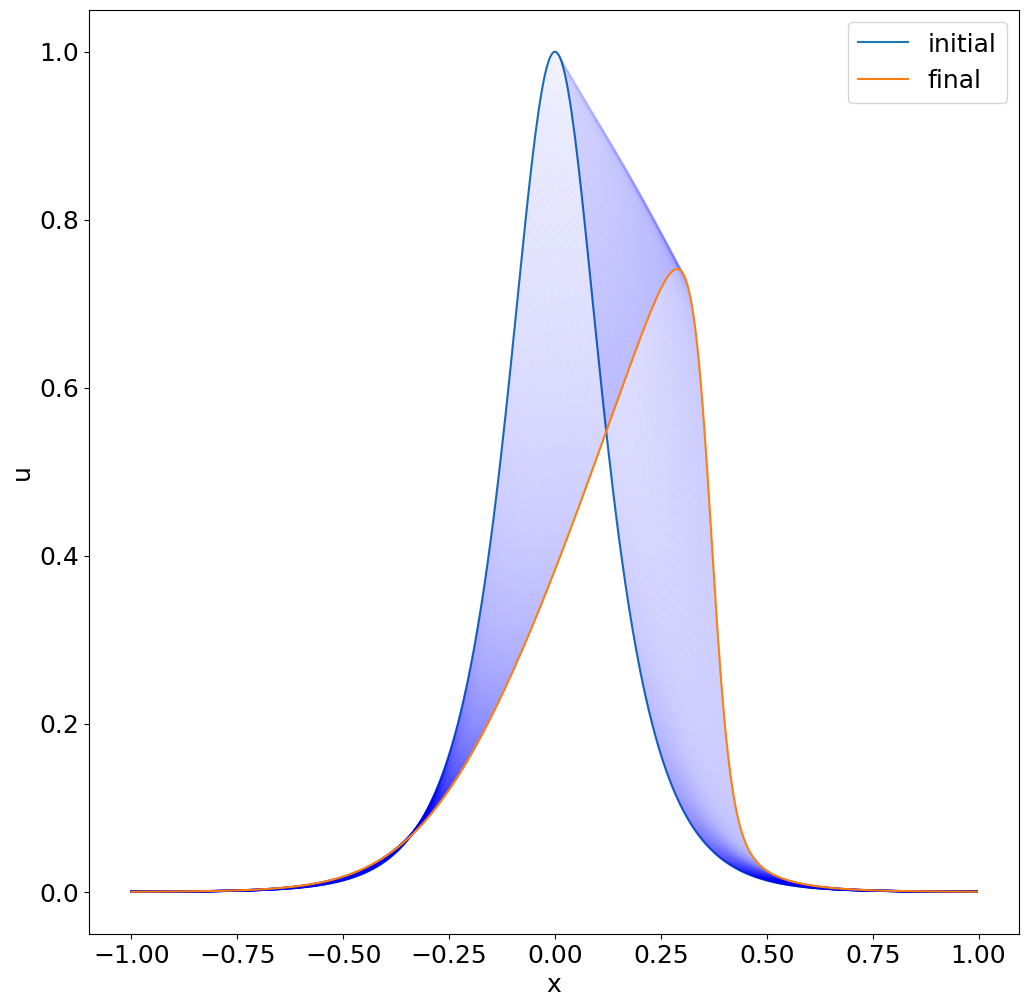

In [39]:
plt.plot(x,uhca[0,:],label="initial")
for i in range(len(uhca)):
    plt.plot(x,uhca[i,:],'b-', alpha=0.08)
plt.plot(x,uhca[-1,:],label="final")
plt.legend()
plt.xlabel("x")
plt.ylabel("u");


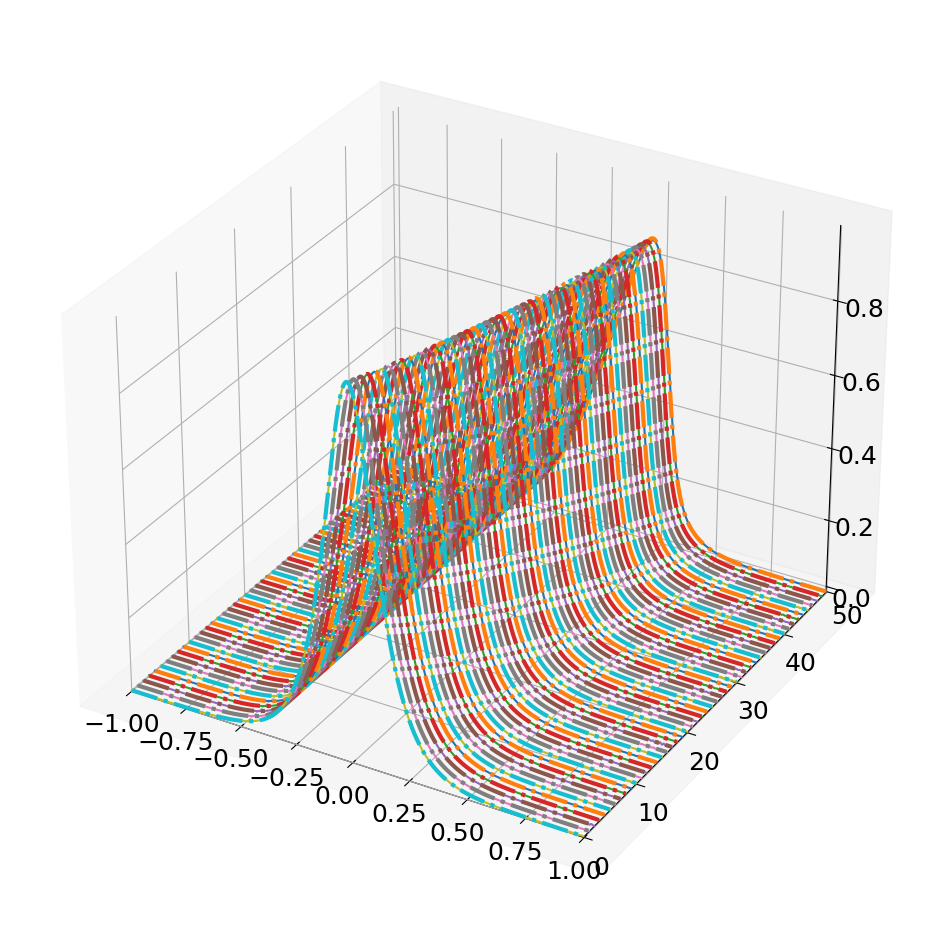

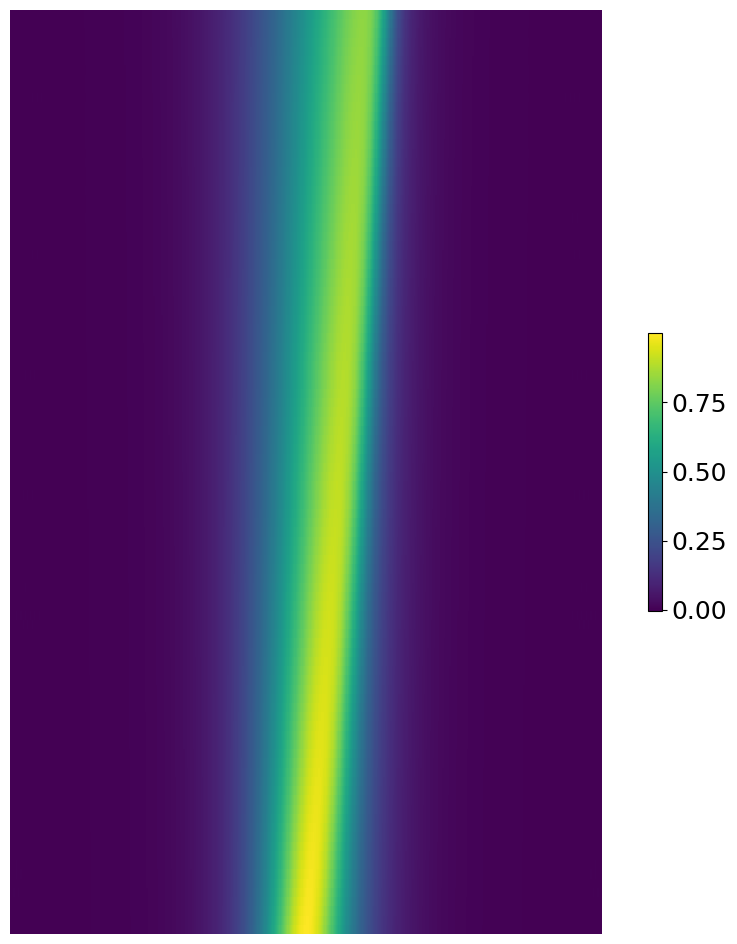

In [14]:
u_plot = u_hc[0:-1:2,:]
ub_plot = u_b[0:-1:2,:]
uhca_plot = uhca[0:-1:2,:]

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for j in range(u_plot.shape[0])[::-1]:
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])
#    ax.plot(x,ys,ub_plot[j,:] ,'--')  # 
    ax.plot(x,ys,uhca_plot[j,:] ,'-.', lw=3)  # 

# Image plot
plt.figure()
plt.imshow(np.flipud(u_hc), aspect=8, interpolation="none")
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.show()

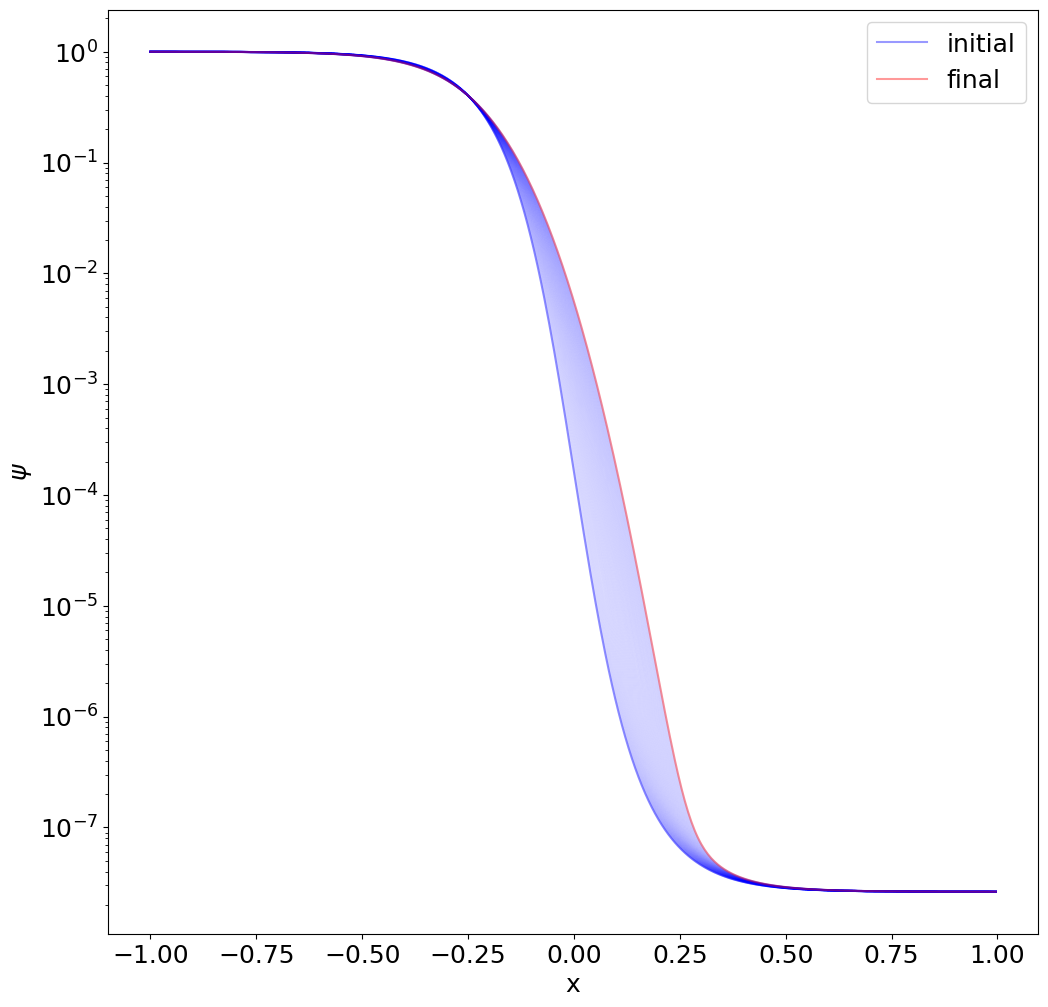

In [15]:
    
# evolution of psi plot
fig = plt.figure()
plt.plot(x,psi0,'b',alpha=.4,label="initial")
for i in range(len(t)):
    plt.plot(x,psi[i,:],'b',alpha=.04)
plt.plot(x,psi[-1,:],'r',alpha=.4,label="final")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\psi$")
plt.yscale("log")    


Wow. This works great. We solved the non-linear Burgers' equation as a simple linear heat equation using the Cole-Hopf transformation. 

### In class exercise:
To better study this and individually go over each aspect let us redo the above evolution of a pulse for a slightly different pulse shape. 

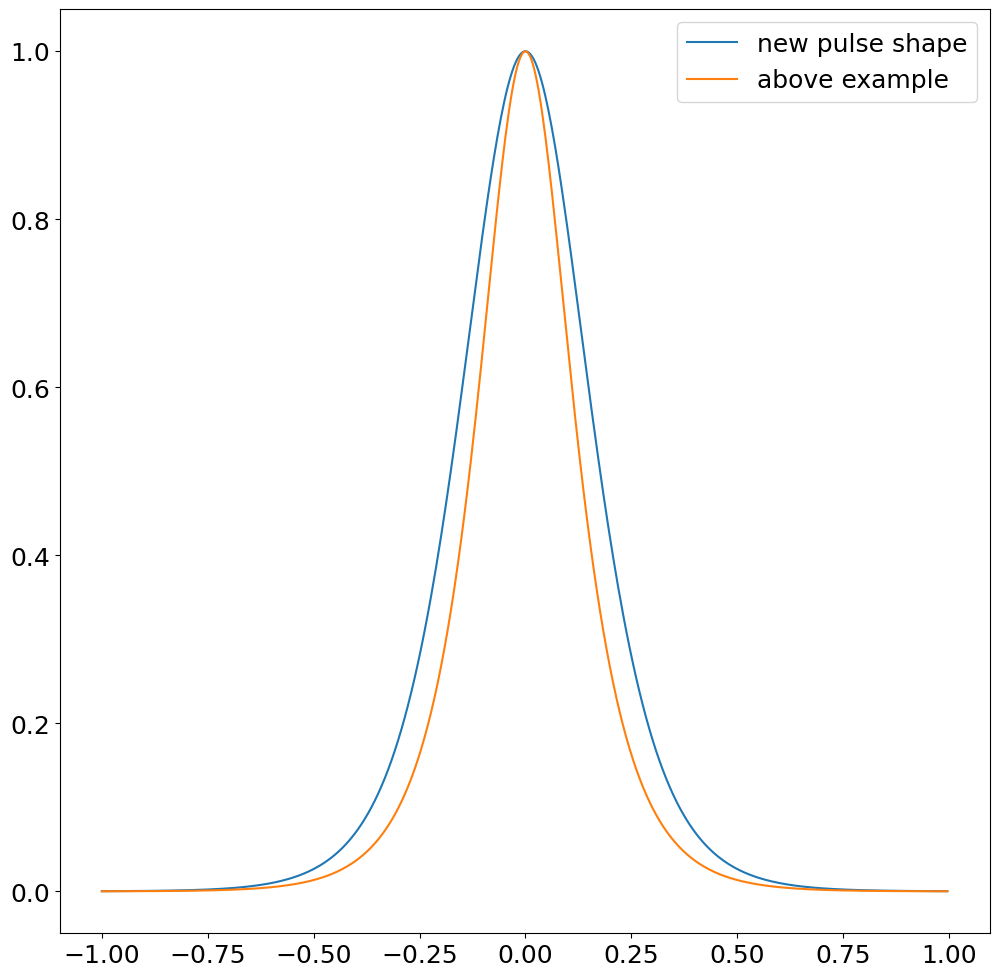

In [16]:
# Initial condition
u10 = 1/np.cosh(x/(L/10))**2
u00 = 1/np.cosh(x/(L/20))
plt.plot(x,u10, label="new pulse shape")
plt.plot(x,u00, label="above example")
plt.legend();

Integrate the Burger's equation as above for the same viscosity $\nu=0.009$ and until $t_{final}=0.25$. 
Compare the final solution of the two pulse shapes. 

**Momentum conservation:** 

Solve for the both a initially uniform density and the pulse velocity shape simultaneously (as above). 
Integrate $\rho \times u$ over the whole volume and plot the resulting value as a function of time for your solution. 
Discuss your results. 

**Use the Hopf-Cole transform to get the evolution of your pulse shape** 

Same as above just for the new pulse shape. Reuse the ```pysym``` code above to integrate the initial pulse.